In [32]:
!pip install selectivesearch
!pip install torch_snippets
!pip install wget

## [download kaggle data in Google Colab](https://www.kaggle.com/general/74235)
* source : [open-images-bus-trucks](https://www.kaggle.com/sixhky/open-images-bus-trucks)

In [33]:
from google.colab import files
files.upload()         # expire any previous token(s) and upload recreated token

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"doranlyong","key":"64e50dac75b9ffadcba793293d86fa8f"}'}

In [34]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

open-images-bus-trucks.zip: Skipping, found more recently modified local copy (use --force to force download)
replace df.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace images/images/0000599864fd15b3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace images/images/0000599864fd15b3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All


***

In [35]:
import selectivesearch
import pandas as pd 
import cv2 
import numpy as np 

import torch 
from torch.utils.data import Dataset 
import torchvision.transforms as T 
from torchvision import datasets, models 
from torch_snippets import * 
from torchvision.ops import nms
#from torch_snippets import Report


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
IMAGE_ROOT = 'images/images'
DF_RAW = pd.read_csv('df.csv')
print(DF_RAW.head())

            ImageID  Source LabelName  ...  XClick2Y  XClick3Y  XClick4Y
0  0000599864fd15b3  xclick       Bus  ...  0.512700  0.650047  0.457197
1  00006bdb1eb5cd74  xclick     Truck  ...  0.241855  0.352130  0.437343
2  00006bdb1eb5cd74  xclick     Truck  ...  0.398496  0.409774  0.295739
3  00010bf498b64bab  xclick       Bus  ...  0.493882  0.705228  0.521691
4  00013f14dd4e168f  xclick       Bus  ...  0.303940  0.999062  0.523452

[5 rows x 21 columns]


In [37]:
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,0,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,0,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,0,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,0,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,0,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


## Data Preprocessing 

In [38]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()

    def __len__(self): 
        return len(self.unique_images)

    def __getitem__(self, idx):
        image_id = self.unique_images[idx]
        image_path = f'{self.root}/{image_id}.jpg'

        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        
        return image, boxes, classes, image_path

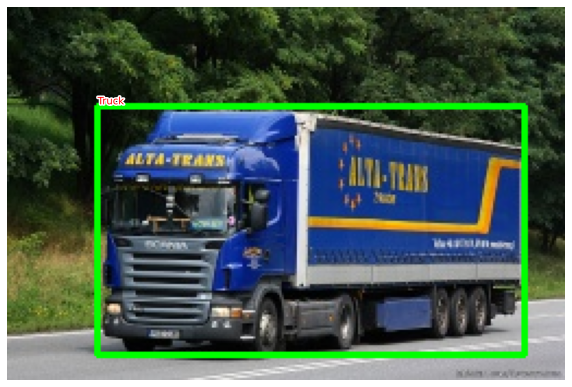

In [39]:
# === Dataset check === # 
ds = OpenImages(df=DF_RAW)
img, bbs, clss, imgPath = ds[9]

show(img, bbs=bbs, texts=clss, sz=10)

## Selective Search & IoU 

In [40]:
# === SelectiveSearch to generate region proposals === # 

def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

In [41]:
def get_iou(boxA, boxB, epsilon=1e-5):
    # === calculate the coordinates of the intersection box === # 
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])

    # === width & height of the overlapping region === # 
    width = (x2 - x1)
    height = (y2 - y1)

    # === area size of overlap === # 
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]) # area of boxA
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1]) # area of boxB
    area_combined = area_a + area_b - area_overlap # boxA U boxB
    iou = area_overlap / (area_combined+epsilon) # the ratio of the overlapping region 
    return iou

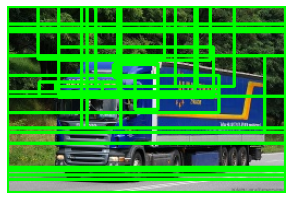

In [42]:
candidates = extract_candidates(np.asarray(img)) # check region proposals 
show(img, bbs = candidates)

In [43]:
bbs

[[41, 45, 237, 159]]

In [44]:
type(img)

numpy.ndarray

IoU over bbox_39=0.5793674251480315, coordinate=[0, 45, 255, 125]


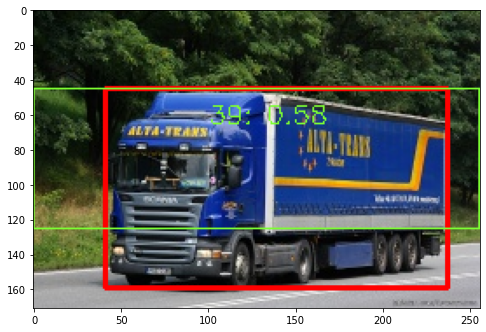

In [45]:
# (ref) https://junha1125.github.io/blog/artificial-intelligence/2020-08-11-SelectiveSearch/
import matplotlib.pyplot as plt

bbox_color = (125, 255, 51) # (R, G, B)
GT = bbs[0]
np_img = np.array(img)

cv2.rectangle(np_img, (GT[0], GT[1]), (GT[2], GT[3]), color=(255,0,0), thickness=2)


for idx, bbox in enumerate(candidates):
    iou = get_iou(bbox, GT)
    
    if iou > 0.55: 
        print(f"IoU over bbox_{idx}={iou}, coordinate={bbox}")
        cv2.rectangle(np_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=bbox_color, thickness=1)
    
        text = f"{idx}: {iou:.2f}"
        cv2.putText(np_img, text, (bbox[0]+100, bbox[1]+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color=bbox_color, thickness=1)

plt.figure(figsize=(8,8))
plt.imshow(np_img)
plt.show()

## Fetching region proposals and the ground truth of offset

In [46]:
DF_RAW.shape

(24062, 21)

In [67]:
""" - FPATHS : lists to store file paths 
    - GTBBS : ground truth bounding boxes 
    - CLSS  : classes of objects 
    - DELTAS : delta offset of a bbox with region proposals 
    - ROIS  : region proposal locations 
    - IOUS : IoU of region proposals with ground truth 
"""

FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []

N = 500   # 샘플개수 ; 500/24062

for idx, (im, bbs, labels, fpath) in enumerate(ds):
    if(idx==N):
        break

    H, W, _ = im.shape
    candidates = extract_candidates(im) # region proposals 
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates]) # cvt (x,y,w,h) system to (x,y,x+w,y+h) system 
                                                                     # pascalVOC format to ... 

    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[get_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T # IoU

    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]

        if best_iou > 0.3: 
            clss.append(labels[best_iou_at])
        else : 
            clss.append('background')

        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H]) # offset ratio 
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))

    FPATHS.append(fpath)
    GTBBS.append(bbs)
    CLSS.append(clss)
    DELTAS.append(deltas)
    ROIS.append(rois)
    IOUS.append(ious)


FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

* ```torch_snippets.flatten``` ([ref](https://github.com/sizhky/torch_snippets))

In [48]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])

label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}

background_class = label2target['background']

In [49]:
targets

,label
0,Bus
1,Bus
2,background
3,Bus
4,background
...,...
3932,Bus
3933,Bus
3934,Bus
3935,Bus


In [50]:
print(label2target)
print(target2label)
print(background_class)

{'Bus': 0, 'background': 1, 'Truck': 2}
{0: 'Bus', 1: 'background', 2: 'Truck'}
1


## Creating the training data 

In [51]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                        )

In [52]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1) # (H,W,C) -> (C,H,W)
    img = normalize(img)
    return img.to(device).float()

def decode(_y):
    _, preds = _y.max(-1)
    return preds

In [53]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas

    def __len__(self): 
        return len(self.fpaths)

    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1] # (BGR) -> (RGB) 
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
            
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)

        return input, labels, deltas

In [54]:
# === Create the training and validation datasets and data loaders === # 

n_train = 9*len(FPATHS)//10

train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

In [55]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, 
                          batch_size=2, 
                          collate_fn=train_ds.collate_fn, 
                          drop_last=True)

test_loader = DataLoader(test_ds, 
                         batch_size=2, 
                         collate_fn=test_ds.collate_fn, 
                         drop_last=True)

## R-CNN network architecture

In [56]:
# === Define a VGG backbone === # 

vgg_backbone = models.vgg16(pretrained=True)

vgg_backbone.classifier = nn.Sequential()  # make it empty for fine-tuning

for param in vgg_backbone.parameters():
    param.requires_grad = False

In [57]:
vgg_backbone.eval()
vgg_backbone.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [58]:
# === Define the RCNN network module === # 

class RCNN(nn.Module):
    def __init__(self):
        super(RCNN,self).__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target)) # classifier 

        self.bbox = nn.Sequential(  nn.Linear(feature_dim, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 4), # bbox coordinate; (xmin, ymin, xmax, ymax)
                                    nn.Tanh(),
                                )
        
        self.cel = nn.CrossEntropyLoss() # for object classification 
        self.sl1 = nn.L1Loss()  # for bbox offset 

    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox

    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        idxs, = torch.where(labels != 0)
        _deltas = _deltas[idxs]
        deltas = deltas[idxs]

        self.lmb = 10.0
        if len(idxs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()

        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [59]:
def train_batch(inputs, model, optimizer, criterion):
    model.train()

    input, clss, deltas = inputs
    _clss, _deltas = model(input)
    accs = clss == decode(_clss)
    
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [64]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

## Run training 

In [65]:
rcnn = RCNN().to(device)

criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)

n_epochs = 5
log = Report(n_epochs)

EPOCH: 5.000	val_loss: 3.456	val_loc_loss: 1.111	val_regr_loss: 0.235	val_acc: 0.565	(833.57s - 0.00s remaining)

100%|██████████| 106/106 [00:00<00:00, 4938.81it/s]


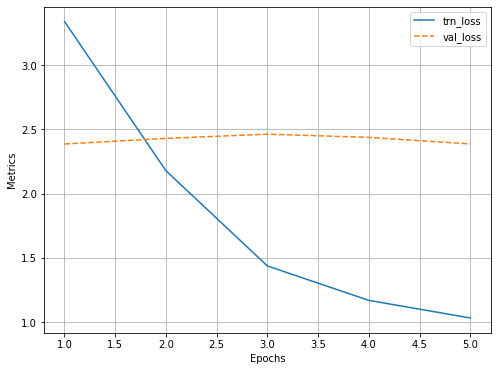

In [68]:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)

        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)

    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

## Inference test 

In [69]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

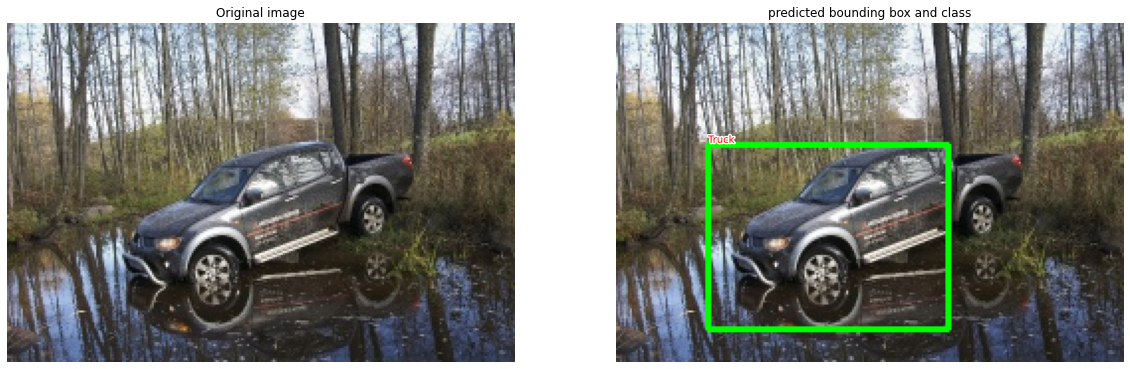

((46, 61, 167, 154), 'Truck', 0.96112084)

In [79]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[6]
test_predictions(fpath)

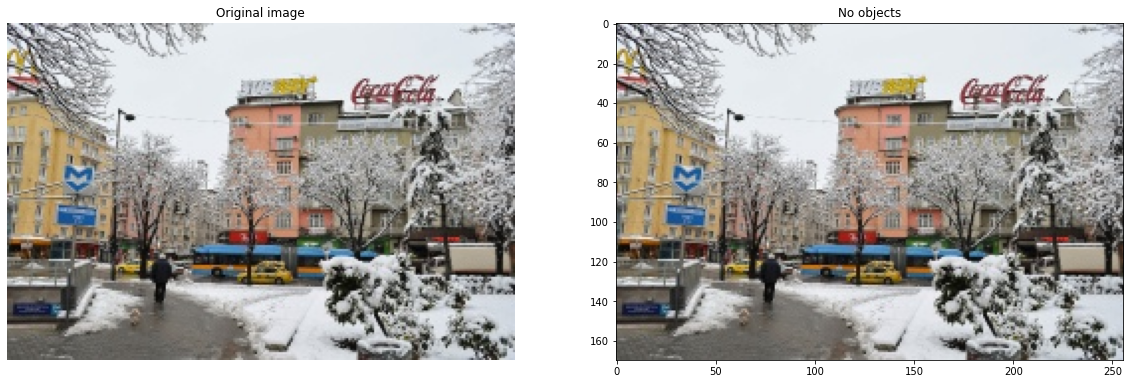

In [80]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[5]
test_predictions(fpath)